In [1]:
x = float(input('Enter a weight (a number less than 1.0): '))
time = input('Enter period start or end: ')
freq = input('Enter frequency (daily, weekly, monthly): ')
factor = input('Enter a factor to test (BBAND, MACD, SMA): ')
factor1 = input('Enter a second factor to test (BBAND, MACD, SMA): ')
factor2 = input('Enter a third factor to test (BBAND, MACD, SMA): ')



Enter a weight (a number less than 1.0): 0.6
Enter period start or end: end
Enter frequency (daily, weekly, monthly): weekly
Enter a factor to test (BBAND, MACD, SMA): BBAND
Enter a second factor to test (BBAND, MACD, SMA): MACD
Enter a third factor to test (BBAND, MACD, SMA): NA


Entire data start date: 2014-09-03
Entire data end date: 2017-12-29
Backtest months: 39


,Backtest
Annual return,nan%
Cumulative returns,-9379595.7%
Annual volatility,4257.7%
Sharpe ratio,-0.66
Calmar ratio,NaN
Stability,NaN
Max drawdown,-1130.9%
Omega ratio,0.71
Sortino ratio,-0.72
Skew,-12.94


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1130.88,2015-08-10,2015-09-24,2015-10-07,43
1,816.61,2015-03-30,2015-07-06,2015-08-10,96
2,348.23,2017-03-01,2017-06-15,NaT,NaN
3,327.21,2014-11-06,2014-12-05,2014-12-12,27
4,291.91,2016-02-16,2016-04-06,2016-09-02,144


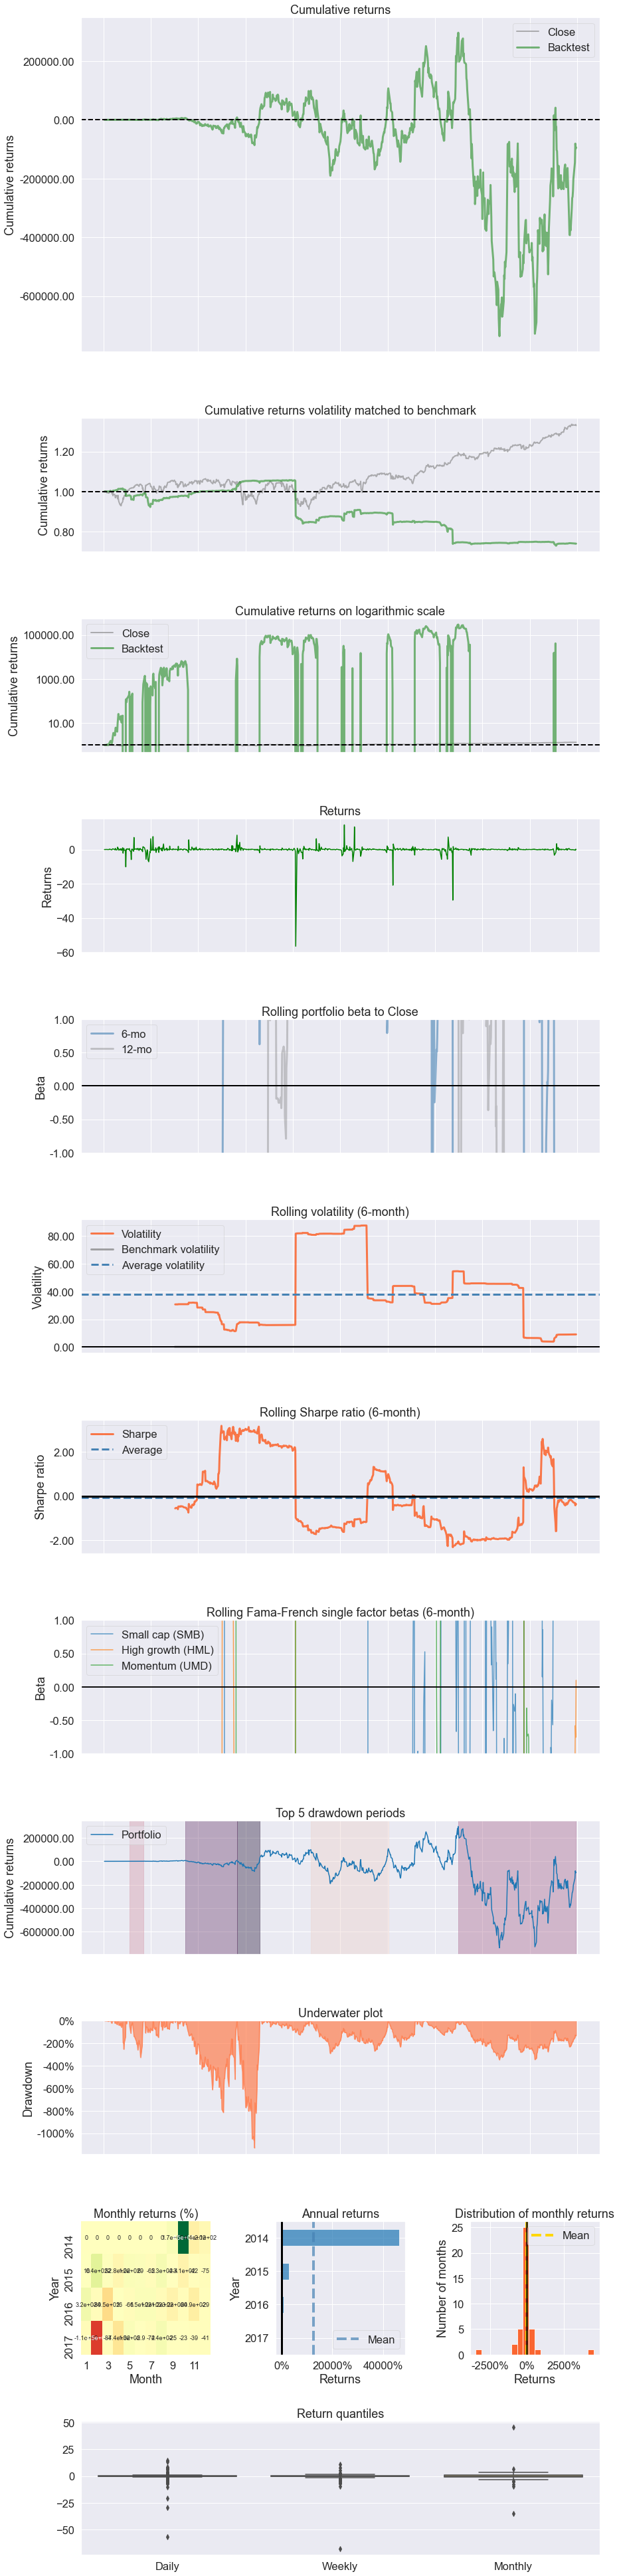

Stress Events,mean,min,max
Oct14,-36.42%,-1014.42%,142.55%
Fall2015,20.33%,-50.23%,419.70%
New Normal,-11.18%,-5655.11%,1441.43%


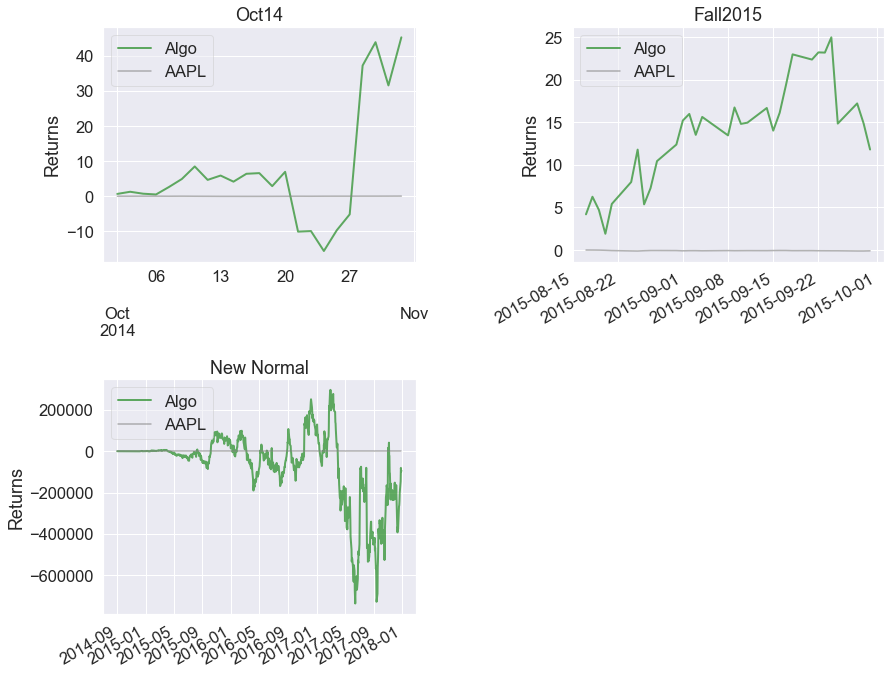

In [6]:
"""
A simple Pipeline algorithm that longs the top 3 stocks by RSI and shorts
the bottom 3 each day.
"""
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import a few libraries we need
from zipline import run_algorithm

from zipline.api import order_target, record, symbol, schedule_function, date_rules, time_rules, order_target_percent, set_benchmark
from datetime import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyfolio as pf
from six import viewkeys
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, data
from zipline.pipeline.factors import RSI, SimpleMovingAverage, BollingerBands, MACDSignal
import pandas as pd
import numpy as np
from zipline.pipeline import CustomFactor
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import AverageDollarVolume, Returns 
import pandas_datareader.data as yahoo_reader
import talib 
from statsmodels.api import OLS, add_constant

class Momentum(CustomFactor):
    # Default inputs
    inputs = [EquityPricing.close]

    # Compute momentum
    def compute(self, today, assets, out, close):
        out[:] = close[-1] / close[0]
        
class sharpe_ratio(CustomFactor):
    inputs = [Returns(inputs = [EquityPricing.close], window_length=2)] #use window_length=2 for daily returns
    window_length=30 #this window_length is for sharpe, i.e. how many days of daily return to use for sharpe
    
    
    def compute(self, today, assets, out, returns):
        out[:] = np.nanmean(returns)/np.nanstd(returns)
    
def get_benchmark(symbol=None, start=None, end=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
    return bm.pct_change(periods=1).fillna(0)

        
def make_pipeline():
    rsi = RSI()
    sharpe_rat = sharpe_ratio()
    long_sharpe = sharpe_rat > 0
    short_sharpe = sharpe_rat < 0
    high, mid, low = BollingerBands(inputs=[EquityPricing.close], window_length=20, k=4)
    oversold = low > EquityPricing.close
    overbought = high > EquityPricing.close
    upper_price_target = mid > EquityPricing.close
    reversal = mid < EquityPricing.close
    macd = MACDSignal(fast_period=12, slow_period=26, signal_period=9) 
    macd_buy = macd > 0 
    macd_sell = macd < 0 
    SMA50 = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=50)
    SMA200 = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=200)
    buy_SMA = SMA50 > SMA200
    sell_SMA = SMA50 < SMA200
    if factor == 'BBAND':
        long_fact = oversold & reversal
        short_fact = overbought & upper_price_target
    elif factor == 'SMA': 
        long_fact = buy_SMA
        short_fact = sell_SMA 
    elif factor == 'MACD': 
        long_fact = macd_buy
        short_fact = macd_sell
    elif factor == 'BBAND' and factor1 =='SMA' or factor1 == 'BBAND' and factor =='SMA':
        long_fact = oversold & reversal & buy_SMA
        short_fact = overbought & upper_price_target & sell_SMA 
    elif factor == 'BBAND' and factor1 == 'MACD' or factor1 == 'BBAND' and factor == 'MACD':
        long_fact = oversold & reversal & macd_buy
        short_fact = overbought & upper_price_target & macd_sell
    elif factor == 'SMA' and factor1 =='MACD' or factor1 == 'SMA' and factor =='MACD':
        long_fact = buy_SMA & macd_buy
        short_fact = sell_SMA  & macd_sell
    else: 
        long_fact = oversold & reversal & macd_buy & buy_SMA
        short_fact = overbought & upper_price_target & macd_sell & sell_SMA
    dollar_volume = AverageDollarVolume(window_length=30)
    high_dollar_volume = (dollar_volume > 12000000)
    #top_20_volume = high_dollar_volume.percentile_between(80, 100)
    latest_close_price = EquityPricing.close.latest
    close_price_filter = latest_close_price > 30
    top_close_price_filter = latest_close_price.top(300)
    
    thirty_day_mom = Momentum(window_length=30)
    momentum_filter = thirty_day_mom>1
    return Pipeline(
        columns={
            'longs': long_fact & sharpe_rat.top(20), 
            'shorts': short_fact & short_sharpe, 
            'stock_sharpe': sharpe_rat 
        },
        screen=close_price_filter  
    )
    


def rebalance(context, data):

    # Pipeline data will be a dataframe with boolean columns named 'longs' and
    # 'shorts'.
    pipeline_data = pipeline_output('my_pipeline')
    all_assets = pipeline_data.index

    longs = all_assets[pipeline_data.longs]
    shorts = all_assets[pipeline_data.shorts]

    record(universe_size=len(all_assets))
    record(pipeline_data.stock_sharpe)
    universe_size= len(set(all_assets))
    

    # Build a 2x-leveraged, equal-weight, long-short portfolio.
    one_third = x/20
    for asset in longs:
        order_target_percent(asset, one_third)

    for asset in shorts:
        order_target_percent(asset, -one_third)

    # Remove any assets that should no longer be in our portfolio.
    portfolio_assets = longs | shorts
    positions = context.portfolio.positions
    for asset in viewkeys(positions) - set(portfolio_assets):
        # This will fail if the asset was removed from our portfolio because it
        # was delisted.
        if data.can_trade(asset):
            order_target_percent(asset, 0)
   
    for asset in context.perm_symbols: 
        order_target_percent(asset,(1-x))
    
            
        



def initialize(context):
    attach_pipeline(make_pipeline(), 'my_pipeline')
    

    # Rebalance each day.  In daily mode, this is equivalent to putting
    # `rebalance` in our handle_data, but in minute mode, it's equivalent to
    # running at the start of the day each day.
    if freq=='daily': 
        schedule_function(rebalance, date_rules.every_day())
    elif freq=='monthly' and time=='end':
        schedule_function(rebalance, date_rules.month_end())
    elif freq=='weekly' and time=='start':
        schedule_function(rebalance, date_rules.week_start())
    elif freq=='weekly' and time=='end':
        schedule_function(rebalance, date_rules.week_end())

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())
    set_benchmark(False)


    context.perm = ['TIF','AEO','NKE','TSN','WFM','TSLA','AMD','WFC','SAM','V','DELL']
    context.perm_symbols = [symbol(s) for s in context.perm]
    


def before_trading_start(context, data):
    context.pipeline_data = pipeline_output('my_pipeline')


def analyze(context, perf):
    fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(14, 8))
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    perf.returns.plot(ax=ax2)
    ax2.set_ylabel('returns')
    plt.legend(loc=0)
    plt.show() 

    

def analyze2(context,perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_full_tear_sheet(returns, benchmark_rets=get_benchmark(symbol="SPY", #this part bechmark_retrns=get_benchmark( here) calls SPY from yahoo and used that as benchmar returns
                                                      start=start.date().isoformat(),
                                                      end=end.date().isoformat()))

    
# Set start and end date

start = pd.Timestamp('2014-9-1', tz='utc')
end = pd.Timestamp('2017-12-31', tz='utc')

# Fire off the backtest
results = run_algorithm(start=start, end=end, 
                                initialize=initialize, analyze=analyze2, 
                                before_trading_start=before_trading_start,
                                handle_data=rebalance, 
                        benchmark_returns=get_benchmark(symbol="SPY", #this part bechmark_retrns=get_benchmark( here) calls SPY from yahoo and used that as benchmar returns
                                                      start=start.date().isoformat(),
                                                      end=end.date().isoformat()),
                                capital_base=10000, 
                                data_frequency = 'daily', bundle='quandl' ) 



In [24]:
#test FFF and sector factors. Test outside algo. use it to discuss sensitivity to specific factors 

In [9]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

{0.0, -0.00316625666338588, 0.017948567979185093, -0.00971348635887015, -0.003581094916293992, 0.1052899689275062, 5.579706914542734, 7.950445647829284, 7.287692291320209, 9.148739648957484, 4.271348996015156, 11.450564531409883, 6.712578877750141, 5.96941472327571, 14.875246107752153, 1.338188278441038, -0.1100263065358894, -0.3116667894402736, 2.8958940470070047, 0.06918726795725427, 0.08318558428938894, 0.21454660209981613, 0.07005943818690286, 0.15895913262180317, -0.054471175330607635, 0.02200681469902932, 0.7269556466896823, 0.058602780960833156, 0.05252526878639041, 0.10157782557772843, -0.06457204674269257, 0.21863108143372845, 0.017191066697251678, -0.01045482855708968, -0.06507272340907633, 0.4027831958785779, 0.024870339638817685, 0.023328006827932457, 0.0889102364850427, -0.01605432777009841, 0.022314486896840124, 0.01888127276176843, 0.08843201693044156, 0.3886726722614511, -0.1899994926661024, 0.3724399755191583, -0.010298986914035968, 0.0016471866289664572, -0.3768287018

In [2]:
#import pandas_datareader.data as web
#from pandas_datareader.famafrench import get_available_datasets
#ff_factor = 'F-F_Research_Data_5_Factors_2x3'
#ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
#ff_portfolio = '17_Industry_Portfolios'
#ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
#ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

#ff_factor_data = ff_factor_data.loc[returns.index]
#ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [ ]:
results.columns

In [ ]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
print(len(set(positions)))

In [8]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
print(set(returns))

{0.0, -0.00316625666338588, 0.017948567979185093, -0.00971348635887015, -0.003581094916293992, 0.1052899689275062, 5.579706914542734, 7.950445647829284, 7.287692291320209, 9.148739648957484, 4.271348996015156, 11.450564531409883, 6.712578877750141, 5.96941472327571, 14.875246107752153, 1.338188278441038, -0.1100263065358894, -0.3116667894402736, 2.8958940470070047, 0.06918726795725427, 0.08318558428938894, 0.21454660209981613, 0.07005943818690286, 0.15895913262180317, -0.054471175330607635, 0.02200681469902932, 0.7269556466896823, 0.058602780960833156, 0.05252526878639041, 0.10157782557772843, -0.06457204674269257, 0.21863108143372845, 0.017191066697251678, -0.01045482855708968, -0.06507272340907633, 0.4027831958785779, 0.024870339638817685, 0.023328006827932457, 0.0889102364850427, -0.01605432777009841, 0.022314486896840124, 0.01888127276176843, 0.08843201693044156, 0.3886726722614511, -0.1899994926661024, 0.3724399755191583, -0.010298986914035968, 0.0016471866289664572, -0.3768287018